# Content
     
**Data Preprocessing**  
- Settings
- Loading Data
- Dealing with missing Values
- Fixing Data Types
- Dealing with Bad Values(Data Imputation)
  - KNN Imputation
- Feature Engieenier
      
**EDA**
- Summary Table
   
**Data Preparation**
- Dealing With Outliers
- Normalization
- Encoding
  
**Modeling**
- Sampling
    - Over Sampling
    - Under Sampling(Choosen)
- Train-Test Split
- Cross Validation
    - Random Forest
    - XGBoost 
    
**Feature Selection**
- Filter Methods
    - Person Correlation, Anova, Chi2
- Embeeded Methods 
  
**Hyperaramters Tunning** 
- Random Forest
- XGBoost 

**Evaluating Best Model**
  
**Test**
- Data Preprossesing/Preparation
- Using Best Model

# Data Preprocessing

In [2]:
### Data Analisy Libraries ###
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

### Machine Learning Libraries ###
from sklearn.model_selection import cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
#from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile


from sklearn.impute import KNNImputer
from math import ceil

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

## Loading Data

In [4]:
data_train_raw = pd.read_csv('train.csv')
data_test_raw = pd.read_csv('test.csv')
data_sub_raw = pd.read_csv('sample_submission.csv')

In [5]:
data = data_train_raw.copy()

In [6]:
data['limite_adicional'].value_counts(), data['limite_adicional'].value_counts(normalize=True)

(Negar       7995
 Conceder    1505
 Name: limite_adicional, dtype: int64,
 Negar      0.84
 Conceder   0.16
 Name: limite_adicional, dtype: float64)

## Dealing with Bad Values(Data Imputation)

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,"9,500.00","6,210.53","3,603.24",1.00,"3,091.75","6,172.50","9,320.25","12,500.00"
idade,"9,500.00",126.40,685.04,18.00,28.00,38.00,47.00,"8,598.00"
saldo_atual,"9,500.00",404.53,217.70,0.09,272.36,337.17,471.26,"1,602.04"
divida_atual,"9,500.00","1,437.09","1,156.26",0.23,573.62,"1,175.73","1,963.33","4,998.07"
renda_anual,"9,500.00","195,037.27","1,454,273.73","10,473.87","26,207.90","45,991.11","80,449.83","23,279,657.98"
valor_em_investimentos,"9,500.00",612.00,"2,002.44",0.00,76.08,134.20,249.18,"10,000.00"
taxa_utilizacao_credito,"9,500.00",32.27,5.11,20.99,28.08,32.26,36.46,49.56
num_emprestimos,"9,500.00",10.86,62.56,0.00,2.00,3.00,6.00,"1,496.00"
num_contas_bancarias,"9,500.00",17.55,120.98,0.00,3.00,6.00,7.00,"1,779.00"
num_cartoes_credito,"9,500.00",21.43,122.68,1.00,4.00,6.00,7.00,"1,479.00"


## KNN Inputation

In [8]:
def nan_transformer(data): 
    '''
    Os valores limiares foram escolhidos baseado nos valores observador no Q3 e usando bom senso, valores absurdos foram considerados Nan
    '''
    data['idade'] = data['idade'].apply(lambda x: np.nan if x > 120 else x)
    data['num_emprestimos'] = data['num_emprestimos'].apply(lambda x: np.nan if x > 30 else x)
    data['num_contas_bancarias'] = data['num_contas_bancarias'].apply(lambda x: np.nan if x > 30 else x)
    data['num_cartoes_credito'] = data['num_cartoes_credito'].apply(lambda x: np.nan if x > 30 else x)
    data['num_pgtos_atrasados'] = data['num_pgtos_atrasados'].apply(lambda x: np.nan if x > 50 else x)
    data['num_consultas_credito'] = data['num_consultas_credito'].apply(lambda x: np.nan if x > 50 else x)
    data['taxa_juros'] = data['taxa_juros'].apply(lambda x: np.nan if x > 99 else x)  

In [9]:
def knn_imputer(X_knn, y_knn=False):
    
    numerical =  X_knn.select_dtypes(include=["number","int64"])#.drop(drop_features, axis=1)
    numerical_features_values = numerical.columns.values
    num_impute = KNNImputer()
    num_impute.fit(X_knn[numerical_features_values])
    X_knn[numerical_features_values] = num_impute.transform(X_knn[numerical_features_values])    

In [10]:
def round_col(data): 
    '''
    O KNN pode fazer grupos om valores fracionados, devemos corrigir isso
    '''
   
    data['idade'] = data['idade'].apply(lambda x: ceil(x)) 
    data['num_emprestimos'] = data['num_emprestimos'].apply(lambda x: ceil(x)) 
    data['num_contas_bancarias'] = data['num_contas_bancarias'].apply(lambda x: ceil(x))
    data['num_cartoes_credito'] = data['num_cartoes_credito'].apply(lambda x: ceil(x))
    data['num_pgtos_atrasados'] = data['num_pgtos_atrasados'].apply(lambda x: ceil(x))
    data['num_consultas_credito'] = data['num_consultas_credito'].apply(lambda x: ceil(x))
    data['taxa_juros'] = data['taxa_juros'].apply(lambda x: ceil(x))   

In [11]:
nan_transformer(data)
y_knn = data['limite_adicional']
X_knn = data.drop(['id_cliente','limite_adicional'], axis=1)
knn_imputer(X_knn, y_knn)
round_col(X_knn)

In [12]:
X_knn.loc[8633]

idade                            36
saldo_atual                  253.54
divida_atual               4,183.81
renda_anual               20,042.06
valor_em_investimentos       104.87
taxa_utilizacao_credito       39.95
num_emprestimos                   6
num_contas_bancarias              9
num_cartoes_credito               5
dias_atraso_dt_venc           35.00
num_pgtos_atrasados              18
num_consultas_credito             6
taxa_juros                       17
investe_exterior                Não
pessoa_polit_exp                Não
Name: 8633, dtype: object

In [13]:
data_new = pd.concat([data[['id_cliente']], X_knn, y_knn],axis=1)

In [14]:
data_new.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

In [15]:
data_new.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,"2,577.05","24,196.90",104.31,31.04,6,5,7,21.00,14,9,15,Não,Não,Negar
1,11920,40,268.87,"2,465.39","19,227.38",69.86,36.92,5,8,5,40.00,23,10,18,Não,Não,Negar
2,8910,36,446.64,"1,055.29","42,822.28",134.20,34.56,0,3,6,26.00,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,"51,786.83",297.35,31.49,0,3,7,12.00,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,"44,626.85",134.20,28.03,2,8,7,24.00,10,8,20,Sim,Não,Negar


## Feature Engieener

In [16]:
# data['dias_adiantamento_dt_venc'] = data['dias_atraso_dt_venc'].copy()
# data['dias_adiantamento_dt_venc'] = data['dias_adiantamento_dt_venc'].apply(lambda x : 0 if x >= 0 else -1*x )
# data['dias_atraso_dt_venc']= data['dias_atraso_dt_venc'].apply(lambda x : 0 if x <= 0 else x )

## EDA

In [16]:
data_eda = data_new.copy()

In [458]:
def display_stats(df):
    
    """
    Descreptive Table   
    """

    df=data.describe()
    skewness=data.skew()
    kurtosis=data.kurtosis()
    df=df.append([skewness, kurtosis],ignore_index=True)
    idx=pd.Series(['count','mean','std','min','25%','50%','75%','max','skewness','kurtosis'],name='Summary Statistic')
    df=pd.concat([df,idx],1).set_index('Summary Statistic')
    df=df.drop('count',axis=0)    
    
    cm = sns.light_palette("#A2A2A2", as_cmap = True)
    display(df.T)

In [459]:
display_stats(data_eda)

C:\Users\Alysson\AppData\Local\Temp/ipykernel_8988/4053549992.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness=data.skew()
C:\Users\Alysson\AppData\Local\Temp/ipykernel_8988/4053549992.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurtosis=data.kurtosis()
C:\Users\Alysson\AppData\Local\Temp/ipykernel_8988/4053549992.py:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df=pd.concat([df,idx],1).set_index('Summary Statistic')


Summary Statistic,mean,std,min,25%,50%,75%,max,skewness,kurtosis
id_cliente,"6,210.53","3,603.24",1.00,"3,091.75","6,172.50","9,320.25","12,500.00",0.01,-1.20
idade,37.68,11.41,18.00,28.00,38.00,46.00,101.00,0.21,-0.85
saldo_atual,404.53,217.70,0.09,272.36,337.17,471.26,"1,602.04",1.62,3.10
divida_atual,"1,437.09","1,156.26",0.23,573.62,"1,175.73","1,963.33","4,998.07",1.19,0.85
renda_anual,"195,037.27","1,454,273.73","10,473.87","26,207.90","45,991.11","80,449.83","23,279,657.98",11.87,149.39
valor_em_investimentos,612.00,"2,002.44",0.00,76.08,134.20,249.18,"10,000.00",4.44,17.87
taxa_utilizacao_credito,32.27,5.11,20.99,28.08,32.26,36.46,49.56,0.04,-0.92
num_emprestimos,3.54,2.45,0.00,2.00,3.00,5.00,19.00,0.46,-0.47
num_contas_bancarias,5.38,2.60,0.00,3.00,6.00,7.00,10.00,-0.19,-0.70
num_cartoes_credito,5.55,2.08,1.00,4.00,5.00,7.00,28.00,0.36,1.20


In [460]:
datacon =data.loc[data['limite_adicional']=='Conceder']
dataneg =data.loc[data['limite_adicional']=='Negar']

In [461]:
datacon['dias_atraso_dt_venc'].median() , dataneg['dias_atraso_dt_venc'].median()

(8.0, 21.0)

In [462]:
datacon['renda_anual'].median() , dataneg['renda_anual'].median()

(69617.7545, 44744.87682)

In [463]:
datacon['divida_atual'].median() , dataneg['divida_atual'].median()

(732.51, 1293.86)

In [464]:
datacon['taxa_juros'].median() , dataneg['taxa_juros'].median()

(6.0, 16.0)

## Data Preparation

In [17]:
data_prep = data_new.copy()

## Dealing with Outliers

In [19]:
def outliers(data, factor=10, p1=0.25, p2=0.75):

    data.drop("renda_anual", axis=1)
    q1 = data.quantile(p1)
    q3 = data.quantile(p2)

    IQR = q3 -q1 
    
    q1_to_min = data < (q1 -factor*IQR)
    q3_to_max = data > (q3 +factor*IQR)
    
    df_without_outliers = data[~((q1_to_min) | (q3_to_max)).any(axis=1)]
    df_with_outliers = data[((q1_to_min) | (q3_to_max)).any(axis=1)]
    
#     df_without_outliers = data[~((data < (q1 -factor*IQR)) | (data > (q3 +factor*IQR))).any(axis=1)]
#     df_with_outliers = data[((data < (q1 -factor*IQR)) | (data > (q3 +factor*IQR))).any(axis=1)]
    print("Rows Dropped:", df_with_outliers.shape[0]) 
    print("Rows Remaning:", len(df_without_outliers))    
    #print(df_without_outliers.limite_adicional.value_counts(normalize=True))
    return df_without_outliers, df_with_outliers

In [20]:
categorical_df, df_outliers =outliers(data_prep, factor=75)

Rows Dropped: 93
Rows Remaning: 9407


C:\Users\Alysson\AppData\Local\Temp/ipykernel_10860/1589817791.py:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  q1_to_min = data < (q1 -factor*IQR)
C:\Users\Alysson\AppData\Local\Temp/ipykernel_10860/1589817791.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  q3_to_max = data > (q3 +factor*IQR)


## Normalization

In [21]:
def apply_log(data):
    drop_features =['id_cliente', 'dias_atraso_dt_venc']    #dias_atraso_dt_venc have negative values which cant be used on log operation
    numerical =  data.select_dtypes(include=["number"]).drop(drop_features, axis=1)
    numerical_features = numerical.columns

    log_columns = data[numerical_features].skew().sort_values(ascending=False)
    log_columns = log_columns.loc[log_columns > 0.75] # to apply log1p only in features with skill higher than 0.75
    for col in log_columns.index:
          data[col] = np.log1p(data_prep[col])             
    #data_prep[numerical_features].hist(figsize=(18,15), bins='auto');


In [22]:
data_prep.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

In [23]:
apply_log(data_prep)

## Encoding

In [24]:
le = LabelEncoder()

data_prep['investe_exterior'] = data_prep['investe_exterior'].apply(lambda x: 0 if x =='Não' else 1)
data_prep['pessoa_polit_exp'] = data_prep['pessoa_polit_exp'].apply(lambda x: 0 if x =='Não' else 1)
data_prep['limite_adicional'] = le.fit_transform(data_prep['limite_adicional'])

# Modeling

## Selected Features

In [25]:
'''
Best Features XGB: taxa_juros, num_cartoes_credito, num_consultas_credito, dias_atraso_dt_venc, num_contas_bancarias
Best Features RF: taxa_juros, num_cartoes_credito, dias_atraso_dt_venc, num_pgmtos, divida_atual

Bellow all default and selected features of Dataframe

'''

target = 'limite_adicional' 


selected_features = [#'saldo_atual',
                     #'idade',
                     'divida_atual', 
                     #'renda_anual',
                     #'valor_em_investimentos', 
                     #'taxa_utilizacao_credito', 
                     'num_emprestimos',
                     'num_contas_bancarias', 
                     'num_cartoes_credito', 
                     'dias_atraso_dt_venc',
                     'num_pgtos_atrasados',
                     'num_consultas_credito', 
                     'taxa_juros',
                     #'investe_exterior', 
                     #'pessoa_polit_exp',
                     #'dias_adiantamento_dt_venc'
                    ] 


y = data_prep[target]
X = data_prep[selected_features]

# Train-Test Split

In [26]:
seed=7
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=seed)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6650, 8), (6650,), (2850, 8), (2850,))

##  Random Forest Classifier

**Holdout and Cross Validation**
 - Standard, up-weight minority class, Over Sampling, Under Sampling

In [27]:
def CM(y, y_pred):
    print("Confusion Matrix:")
    labels = ["Conceder", "Negar"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="binary", values_format="d")  
    plt.show() 
    print("Metrics \n", classification_report(y,y_pred))   

In [28]:
def holdout(model, X, y):    
    model.fit(X, y)
    y_pred = model.predict(X_val)
    CM(y_val,y_pred)
    n=25
    print(f"first {n} Predictions: {y_pred[0:n]}\n")       

### Holdout

In [29]:
#rf = RandomForestClassifier(random_state=seed)

In [30]:
# #Holdout
# holdout(rf, X_train, y_train)

In [31]:
# #Holdout
# smt=SMOTE()
# X_resampled, y_resampled = smt.fit_resample(X_train,y_train)
# print("Minority/Majority Class, Non-Smote:", np.bincount(y))
# print("Minority/Majority Class, Smote:", np.bincount(y_resampled))
# print("\n")

# holdout(rf, X_resampled, y_resampled)

In [32]:
# # #Holdout
# tl = TomekLinks()
# X_resampled, y_resampled = tl.fit_resample(X_train,y_train)
# print("Minority/Majority Class, Non-TomekLinks:", np.bincount(y))
# print("Minority/Majority Class, TomekLinks:", np.bincount(y_resampled))
# print("\n")

# holdout(rf, X_resampled, y_resampled)

### Cross Validation

In [33]:
def CVS(model, X, y, model_dict=''):    
    
    number_folds = 4
    #Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=seed)
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=seed)
    
    scoring = {'Accuracy': make_scorer(accuracy_score),
               'Precision': make_scorer(precision_score),
               'f1': make_scorer(f1_score),
               'Recall': make_scorer(recall_score)}    

    y_pred = cross_val_predict(model, X, y, cv=number_folds, method='predict')
   
    CM(y,y_pred)
   
    scores = cross_validate(model, X, y, cv = Kfold, scoring=scoring)
    
    for chave, valor in scores.items():
        print(f"{chave}, over {number_folds} folds attempts: {round(np.mean(valor),5)} +/- {round(np.std(valor),5)}")        
    print("\n") 
    print(f"Minority/Majority Class Prediction, {model_dict}:", np.bincount(y_pred))
    print("\n")
    n=25
    print(f"First {n} Predictions: {y_pred[0:n]}\nLast {n} Predictions: {y_pred[n:0:-1]} \n")   
    
    return y_pred

In [34]:
## Random Forest - Without Sampling technique
rf_standard = RandomForestClassifier()

## Random Forest - Applying up-weight on Minority Class
weight = int(y.value_counts()[1]/y.value_counts()[0])
rf_weighted = RandomForestClassifier(class_weight={0: 1, 1: weight})


## Random Forest - Applying OverSampling, SMOTE
rf_oversampled = make_pipeline(
        SMOTE(),
        RandomForestClassifier())

## Random Forest - Applying UnderSampling, TomekLink
rf_undersampled = make_pipeline(
        TomekLinks(),
        RandomForestClassifier())

*****************************************************
Random Forest - Without Sampling Technique
*****************************************************
Confusion Matrix:


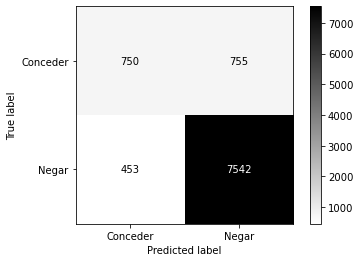

Metrics 
               precision    recall  f1-score   support

           0       0.62      0.50      0.55      1505
           1       0.91      0.94      0.93      7995

    accuracy                           0.87      9500
   macro avg       0.77      0.72      0.74      9500
weighted avg       0.86      0.87      0.87      9500

fit_time, over 4 folds attempts: 0.33791 +/- 0.0041
score_time, over 4 folds attempts: 0.0282 +/- 0.00063
test_Accuracy, over 4 folds attempts: 0.87389 +/- 0.00645
test_Precision, over 4 folds attempts: 0.90901 +/- 0.00064
test_f1, over 4 folds attempts: 0.92651 +/- 0.00403
test_Recall, over 4 folds attempts: 0.94472 +/- 0.00786


Minority/Majority Class Prediction, Random Forest - Without Sampling Technique: [1203 8297]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

*****************************************************
Random Forest - Applying up-weigh

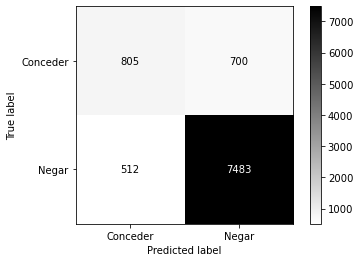

Metrics 
               precision    recall  f1-score   support

           0       0.61      0.53      0.57      1505
           1       0.91      0.94      0.93      7995

    accuracy                           0.87      9500
   macro avg       0.76      0.74      0.75      9500
weighted avg       0.87      0.87      0.87      9500

fit_time, over 4 folds attempts: 0.35232 +/- 0.00506
score_time, over 4 folds attempts: 0.02828 +/- 0.00042
test_Accuracy, over 4 folds attempts: 0.87158 +/- 0.00639
test_Precision, over 4 folds attempts: 0.91427 +/- 0.00066
test_f1, over 4 folds attempts: 0.92454 +/- 0.00407
test_Recall, over 4 folds attempts: 0.93508 +/- 0.0082


Minority/Majority Class Prediction, Random Forest - Applying up-weight on Minority Class: [1317 8183]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

*****************************************************
Random Forest - Applyi

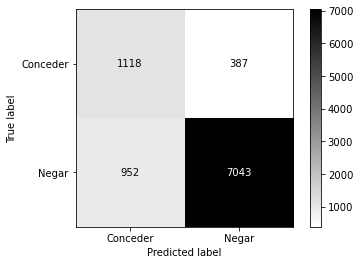

Metrics 
               precision    recall  f1-score   support

           0       0.54      0.74      0.63      1505
           1       0.95      0.88      0.91      7995

    accuracy                           0.86      9500
   macro avg       0.74      0.81      0.77      9500
weighted avg       0.88      0.86      0.87      9500

fit_time, over 4 folds attempts: 0.71653 +/- 0.00617
score_time, over 4 folds attempts: 0.03153 +/- 0.00051
test_Accuracy, over 4 folds attempts: 0.85695 +/- 0.0041
test_Precision, over 4 folds attempts: 0.94822 +/- 0.0057
test_f1, over 4 folds attempts: 0.91173 +/- 0.00298
test_Recall, over 4 folds attempts: 0.87805 +/- 0.00893


Minority/Majority Class Prediction, Random Forest - Applying OverSampling, SMOTE: [2070 7430]


First 25 Predictions: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1] 

*****************************************************
Random Forest - Applying UnderS

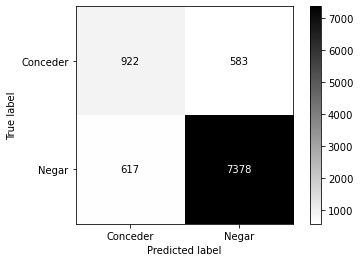

Metrics 
               precision    recall  f1-score   support

           0       0.60      0.61      0.61      1505
           1       0.93      0.92      0.92      7995

    accuracy                           0.87      9500
   macro avg       0.76      0.77      0.77      9500
weighted avg       0.87      0.87      0.87      9500

fit_time, over 4 folds attempts: 0.40217 +/- 0.02741
score_time, over 4 folds attempts: 0.02801 +/- 0.00069
test_Accuracy, over 4 folds attempts: 0.874 +/- 0.00372
test_Precision, over 4 folds attempts: 0.92843 +/- 0.00264
test_f1, over 4 folds attempts: 0.92485 +/- 0.00245
test_Recall, over 4 folds attempts: 0.92133 +/- 0.00598


Minority/Majority Class Prediction, Random Forest - Applying UnderSampling, Tomkelink: [1539 7961]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 



In [35]:
pipelines_rf = [rf_standard, rf_weighted, rf_oversampled, rf_undersampled]
pipe_dict_rf = {0:'Random Forest - Without Sampling Technique', 
                1:'Random Forest - Applying up-weight on Minority Class', 
                2:'Random Forest - Applying OverSampling, SMOTE',
                3:'Random Forest - Applying UnderSampling, Tomkelink'}

for i,model in enumerate(pipelines_rf): 
    print('*' * 53) 
    print(f"{pipe_dict_rf[i]}") 
    print('*' * 53)     
    CVS(model,X,y,pipe_dict_rf[i])    

## XGBOOST Classifier

**Holdout**
 - Standard, up-weight minority class, Over Sampling, Under Sampling
 
**Cross Validation**
  - Standard, up-weight minority class, Over Sampling, Under Sampling

### Holdout

In [36]:
# xgb= XGBClassifier(random_state=seed)

In [37]:
#Holdout - Using OverSampling technique, SMOTE
# holdout(xgb, X_train, y_train)

In [38]:
# #Holdout - Using OverSampling technique, SMOTE
# smt=SMOTE()
# X_resampled, y_resampled = smt.fit_resample(X_train,y_train)
# print("Minority/Majority Class, Non-Smote:", np.bincount(y))
# print("Minority/Majority Class, Smote:", np.bincount(y_resampled))

# holdout(xgb, X_resampled, y_resampled)

In [42]:
## XGBOOST Classifier - Without Sampling technique
xgb_standard = XGBClassifier()

## XGBOOST Classifier - Applying up-weight on Minority Class
weight = int(y.value_counts()[1]/y.value_counts()[0])
xgb_weighted = XGBClassifier(scale_pos_weight=weight)


## XGBOOST Classifier - Applying OverSampling, SMOTE
xgb_oversampled = make_pipeline(
        SMOTE(),
        XGBClassifier())

## XGBOOST Classifier - Applying UnderSampling, TomekLink
xgb_undersampled = make_pipeline(
        TomekLinks(),
        XGBClassifier())

*****************************************************
XGBoost Classifier - Without Sampling Technique
*****************************************************
Confusion Matrix:


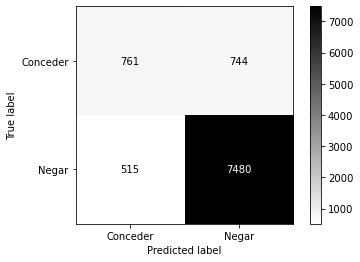

Metrics 
               precision    recall  f1-score   support

           0       0.60      0.51      0.55      1505
           1       0.91      0.94      0.92      7995

    accuracy                           0.87      9500
   macro avg       0.75      0.72      0.73      9500
weighted avg       0.86      0.87      0.86      9500

fit_time, over 4 folds attempts: 0.19075 +/- 0.00258
score_time, over 4 folds attempts: 0.008 +/- 0.0
test_Accuracy, over 4 folds attempts: 0.86463 +/- 0.00576
test_Precision, over 4 folds attempts: 0.90747 +/- 0.00343
test_f1, over 4 folds attempts: 0.92074 +/- 0.00369
test_Recall, over 4 folds attempts: 0.93446 +/- 0.00857


Minority/Majority Class Prediction, : [1276 8224]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

*****************************************************
XGBoost Classifier - Applying up-weight on Minority Class
*********************

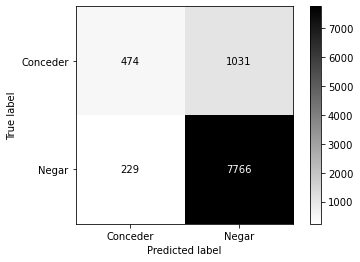

Metrics 
               precision    recall  f1-score   support

           0       0.67      0.31      0.43      1505
           1       0.88      0.97      0.92      7995

    accuracy                           0.87      9500
   macro avg       0.78      0.64      0.68      9500
weighted avg       0.85      0.87      0.85      9500

fit_time, over 4 folds attempts: 0.1915 +/- 0.0026
score_time, over 4 folds attempts: 0.00725 +/- 0.00043
test_Accuracy, over 4 folds attempts: 0.87032 +/- 0.00328
test_Precision, over 4 folds attempts: 0.88164 +/- 0.00409
test_f1, over 4 folds attempts: 0.92691 +/- 0.00171
test_Recall, over 4 folds attempts: 0.97711 +/- 0.00332


Minority/Majority Class Prediction, : [ 703 8797]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

*****************************************************
XGBoost Classifier - Applying OverSampling, SMOTE
*************************

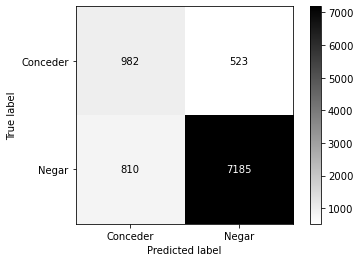

Metrics 
               precision    recall  f1-score   support

           0       0.55      0.65      0.60      1505
           1       0.93      0.90      0.92      7995

    accuracy                           0.86      9500
   macro avg       0.74      0.78      0.76      9500
weighted avg       0.87      0.86      0.86      9500

fit_time, over 4 folds attempts: 0.38077 +/- 0.03355
score_time, over 4 folds attempts: 0.008 +/- 0.00071
test_Accuracy, over 4 folds attempts: 0.86021 +/- 0.00542
test_Precision, over 4 folds attempts: 0.93294 +/- 0.00567
test_f1, over 4 folds attempts: 0.91538 +/- 0.00361
test_Recall, over 4 folds attempts: 0.89856 +/- 0.00906


Minority/Majority Class Prediction, : [1792 7708]


First 25 Predictions: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1] 

*****************************************************
XGBoost Classifier - Applying UnderSampling, TomekLink
********************

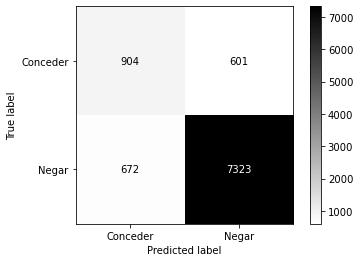

Metrics 
               precision    recall  f1-score   support

           0       0.57      0.60      0.59      1505
           1       0.92      0.92      0.92      7995

    accuracy                           0.87      9500
   macro avg       0.75      0.76      0.75      9500
weighted avg       0.87      0.87      0.87      9500

fit_time, over 4 folds attempts: 0.267 +/- 0.0151
score_time, over 4 folds attempts: 0.0075 +/- 0.0005
test_Accuracy, over 4 folds attempts: 0.86253 +/- 0.00745
test_Precision, over 4 folds attempts: 0.92149 +/- 0.00305
test_f1, over 4 folds attempts: 0.918 +/- 0.00472
test_Recall, over 4 folds attempts: 0.91457 +/- 0.00823


Minority/Majority Class Prediction, : [1576 7924]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 



In [43]:
pipelines_xgb = [xgb_standard, xgb_weighted, xgb_oversampled, xgb_undersampled]
pipe_dict_xgb = {0:'XGBoost Classifier - Without Sampling Technique', 
                 1:'XGBoost Classifier - Applying up-weight on Minority Class', 
                 2:'XGBoost Classifier - Applying OverSampling, SMOTE',
                 3:'XGBoost Classifier - Applying UnderSampling, TomekLink'}

for i,model in enumerate(pipelines_xgb):    
    print('*' * 53) 
    print(f"{pipe_dict_xgb[i]}") 
    print('*' * 53)
    CVS(model,X,y)    

# Feature Selection 

**By Univariated Selection**
- Pearson Correlation
- SelectkBest - Anova
    
**By Importance - Tree Based Algorithms**
- Random Forest
- XGBoost
    
**By Mutal Information**

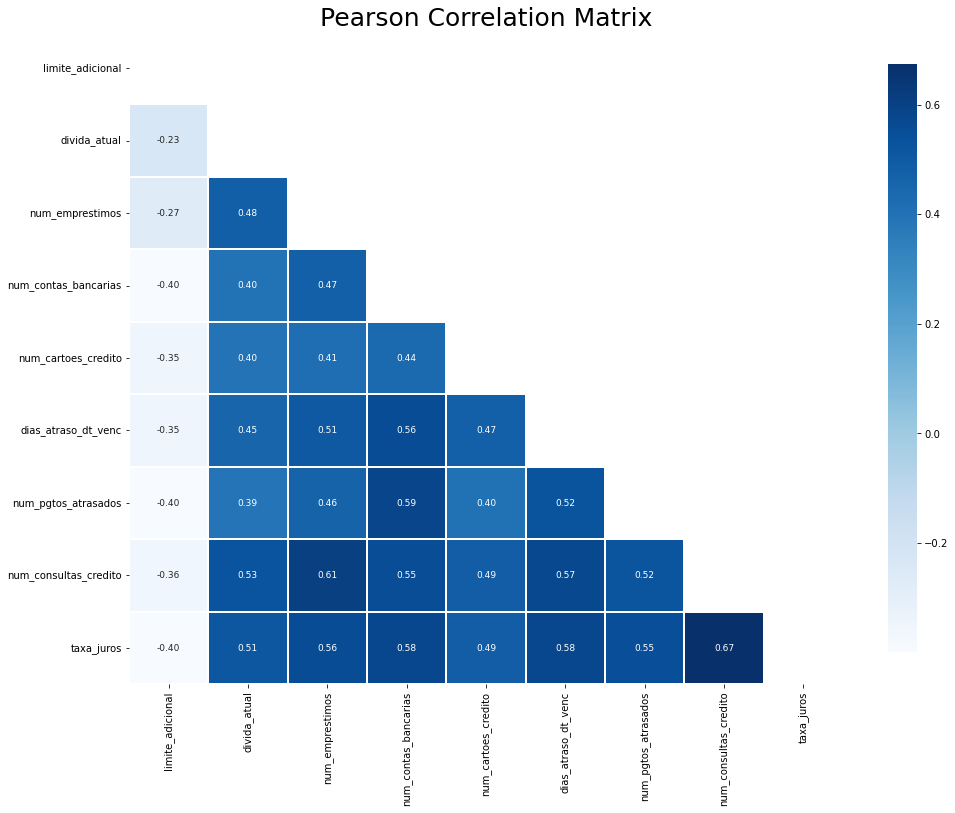

In [491]:
## Need to check if I can use normalized dada not the original?!?!?

selected_numerical = pd.concat([-y, X],axis=1) #-y means if pearson conrrelation is negative

mask = np.zeros_like(selected_numerical.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(selected_numerical.corr(method='pearson'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [492]:
selected_numerical.corr()['limite_adicional'].abs().sort_values(ascending = False)

limite_adicional        1.00
taxa_juros              0.40
num_pgtos_atrasados     0.40
num_contas_bancarias    0.40
num_consultas_credito   0.36
dias_atraso_dt_venc     0.35
num_cartoes_credito     0.35
num_emprestimos         0.27
divida_atual            0.23
Name: limite_adicional, dtype: float64

In [493]:
X_sel = X.copy()

numerical_df = data_prep.select_dtypes(include = ['int64','float64']).drop("id_cliente", axis=1)
categorical_df = X_sel[['investe_exterior','pessoa_polit_exp']]

KeyError: "None of [Index(['investe_exterior', 'pessoa_polit_exp'], dtype='object')] are in the [columns]"

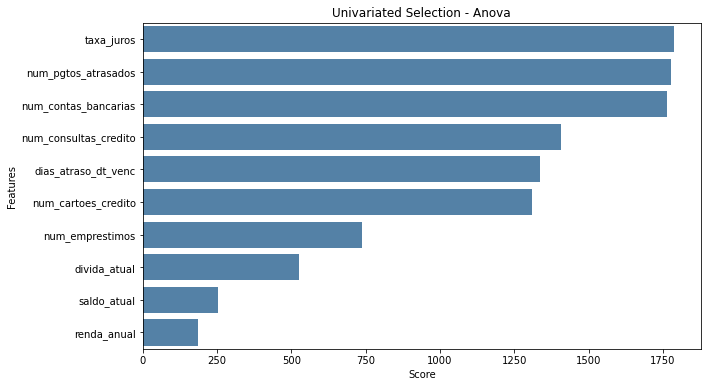

In [494]:
### Apply SelectKBest Algorithm - Anova
anova = SelectKBest(score_func=f_classif, k=10).fit(numerical_df,y)
anova_scores=pd.DataFrame(anova.scores_,columns=["Score"])
anova_columns=pd.DataFrame(numerical_df.columns)
anova_feature_rank=pd.concat([anova_columns,anova_scores],axis=1)
anova_feature_rank.columns=['Features','Score']
anova_feature_rank=anova_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Anova')
sns.barplot(data=anova_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

In [497]:
# ### Apply SelectKBest Algorithm - Chi2
# chi2 = SelectKBest(score_func=chi2, k=2).fit(categorical_df,y)
# chi2_scores=pd.DataFrame(chi2.scores_,columns=["Score"])
# chi2_columns=pd.DataFrame(categorical_df.columns)
# chi2_feature_rank=pd.concat([chi2_columns,anova_scores],axis=1)
# chi2_feature_rank.columns=['Features','Score']
# chi2_feature_rank=chi2_feature_rank.nlargest(10,'Score')

# plt.figure(figsize=(10,6))
# plt.title('Univariated Selection - Chi2')
# sns.barplot(data=chi2_feature_rank, x='Score', y='Features', color='SteelBlue');
# plt.show()

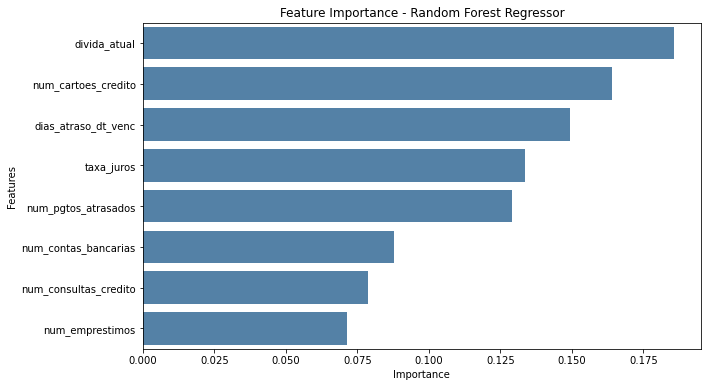

In [498]:
rf = RandomForestClassifier(class_weight={0: 1, 1: weight}, random_state=seed)
rf.fit(X_train,y_train)

fi_rf = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.title('Feature Importance - Random Forest Regressor')
sns.barplot(data=fi_rf.head(10), x='Importance', y='Features', color='SteelBlue');
plt.show()

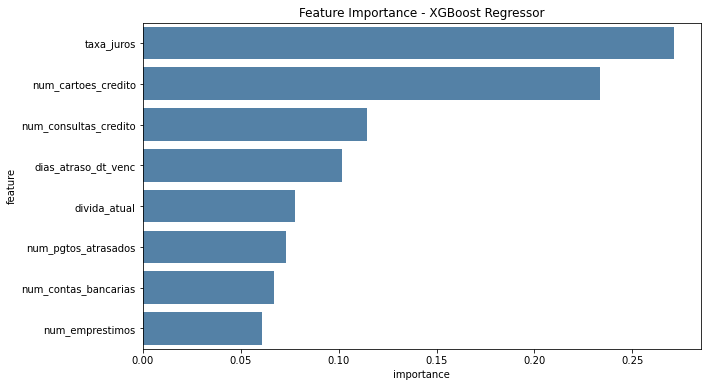

In [499]:
xgb = XGBClassifier(scale_pos_weight=weight, random_state=seed)
xgb.fit(X_train,y_train)

fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance - XGBoost Regressor')
sns.barplot(data=fi_xgb.head(10), x='importance', y='feature', color='SteelBlue');
plt.show()

# Hyperparamters Tunning


As our database is relatively small, we will use gridsearchcv

## Random Forest Tunning

In [355]:
# np.random.seed(7)

# params  = {'criterion': ['entropy', 'gini'],
#                'max_depth': [3,6,9,12],
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 4, 6, 8],
#                'min_samples_split': [5, 7,10],
#                'n_estimators': [100,200,300],
#                'class_weight':[0, weight]}


# rf = RandomForestClassifier(random_state=seed)

# gs = GridSearchCV(estimator = rf, param_grid = params, cv = 3, scoring='f1', verbose= True, n_jobs = -1)
# gs.fit(X_train,y_train)

# rf_tuning_score = gs.best_score_
# predict_rf_tunning = gs.best_estimator_.predict(X_val)

# CM(y_val, predict_rf_tunning)

# print(f"\nF1 Best Score:{gs.best_score_}") 
# print(f"\nBest Paramters:\n{gs.best_params_}") 
# print(f"\nBest Estimator:\n{gs.best_estimator_}")

## XGBoost Tunning

Confusion Matrix:


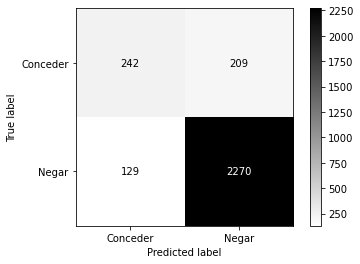

Metrics 
               precision    recall  f1-score   support

           0       0.65      0.54      0.59       451
           1       0.92      0.95      0.93      2399

    accuracy                           0.88      2850
   macro avg       0.78      0.74      0.76      2850
weighted avg       0.87      0.88      0.88      2850


F1 Score Traning:0.9309240456752782,F1 Score Validation:0.930709307093071

Best Paramters:
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}

Best Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1

In [44]:
np.random.seed(7)

params = {
    "learning_rate":[0.05,0.10,0.15],
    "max_depth":[6,9,12,15], 
    #"min_child_weight":[1,3,5,7],
    #"gamma":[0.1,0.2,0.3],
    #"colsample_bytree":[0.5, 0.7, 0.9],
    'n_estimators':[100,200,300],
    #'subsample': [0,0.5]
    #'scale_pos_weight':[0, weight/2, weight]
}

xgb = XGBClassifier()

gs = GridSearchCV(estimator = xgb, param_grid=params, scoring='f1', cv=3)

gs.fit(X_train,y_train)
y_pred_xgb_tunning = gs.best_estimator_.predict(X_val)

CM(y_val, y_pred_xgb_tunning)

val_score = gs.score(X_val, y_val)

print(f"\nF1 Score Traning:{gs.best_score_},F1 Score Validation:{val_score}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}")

In [45]:
from hyperopt import hp
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope

# XGB parameters
xgb_reg_params = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 100)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'alpha': hp.loguniform('alpha', -10, 10),
    'lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'binary:logistic',
    'seed': 123,
}
xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

class HPOpt(object):

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **para['fit_params'])
        pred = reg.predict(self.X_val)
        loss = para['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

obj = HPOpt(X_train, X_val, y_train, y_val)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

  1%|▍                                              | 1/100 [00:00<00:20,  4.85trial/s, best loss: 0.29387365446214486]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  2%|▉                                              | 2/100 [00:00<00:18,  5.31trial/s, best loss: 0.29387365446214486]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

  3%|█▍                                             | 3/100 [00:00<00:18,  5.24trial/s, best loss: 0.29387365446214486]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

  5%|██▎                                            | 5/100 [00:00<00:18,  5.18trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  7%|███▎                                           | 7/100 [00:01<00:16,  5.68trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

  8%|███▊                                           | 8/100 [00:01<00:14,  6.20trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 12%|█████▌                                        | 12/100 [00:01<00:10,  8.44trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 14%|██████▍                                       | 14/100 [00:02<00:09,  8.68trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 17%|███████▊                                      | 17/100 [00:02<00:06, 11.94trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 21%|█████████▋                                    | 21/100 [00:02<00:07, 11.06trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 24%|███████████                                   | 24/100 [00:03<00:11,  6.61trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 26%|███████████▉                                  | 26/100 [00:03<00:10,  6.99trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 29%|█████████████▎                                | 29/100 [00:03<00:08,  8.26trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 31%|██████████████▎                               | 31/100 [00:04<00:10,  6.62trial/s, best loss: 0.27962059250952537]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 33%|███████████████▏                              | 33/100 [00:04<00:08,  7.69trial/s, best loss: 0.27959525634850035]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 35%|████████████████                              | 35/100 [00:04<00:10,  6.36trial/s, best loss: 0.27959525634850035]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 36%|████████████████▌                             | 36/100 [00:04<00:09,  7.04trial/s, best loss: 0.27959525634850035]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 38%|██████████████████▏                             | 38/100 [00:05<00:07,  8.44trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 40%|███████████████████▏                            | 40/100 [00:05<00:09,  6.47trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 41%|███████████████████▋                            | 41/100 [00:05<00:10,  5.85trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 45%|█████████████████████▌                          | 45/100 [00:06<00:08,  6.83trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 48%|███████████████████████                         | 48/100 [00:06<00:07,  7.29trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 50%|████████████████████████                        | 50/100 [00:06<00:06,  7.15trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 54%|█████████████████████████▉                      | 54/100 [00:07<00:04,  9.76trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 56%|██████████████████████████▉                     | 56/100 [00:07<00:04, 10.59trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 58%|███████████████████████████▊                    | 58/100 [00:07<00:03, 10.98trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 60%|████████████████████████████▊                   | 60/100 [00:08<00:04,  8.04trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 63%|██████████████████████████████▏                 | 63/100 [00:08<00:05,  7.38trial/s, best loss: 0.279487490534504]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 66%|███████████████████████████████                | 66/100 [00:08<00:04,  8.38trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 69%|████████████████████████████████▍              | 69/100 [00:09<00:03,  8.80trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 70%|████████████████████████████████▉              | 70/100 [00:09<00:03,  8.41trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 72%|█████████████████████████████████▊             | 72/100 [00:09<00:03,  8.19trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 74%|██████████████████████████████████▊            | 74/100 [00:09<00:02,  8.80trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 76%|███████████████████████████████████▋           | 76/100 [00:10<00:03,  7.82trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 77%|████████████████████████████████████▏          | 77/100 [00:10<00:03,  7.31trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 79%|█████████████████████████████████████▏         | 79/100 [00:10<00:03,  6.32trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 81%|██████████████████████████████████████         | 81/100 [00:10<00:02,  6.49trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 83%|███████████████████████████████████████        | 83/100 [00:11<00:02,  7.59trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 87%|████████████████████████████████████████▉      | 87/100 [00:11<00:01,  9.70trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 89%|█████████████████████████████████████████▊     | 89/100 [00:11<00:01,  8.34trial/s, best loss: 0.2778645431269406]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 91%|██████████████████████████████████████████▊    | 91/100 [00:11<00:01,  8.61trial/s, best loss: 0.2776631791837371]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 95%|████████████████████████████████████████████▋  | 95/100 [00:12<00:00, 11.25trial/s, best loss: 0.2776631791837371]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 97%|████████████████████████████████████████████▌ | 97/100 [00:12<00:00,  9.65trial/s, best loss: 0.27712597192953803]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

 99%|█████████████████████████████████████████████▌| 99/100 [00:12<00:00, 10.04trial/s, best loss: 0.27712597192953803]

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\Alysson\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead

100%|█████████████████████████████████████████████| 100/100 [00:12<00:00,  7.74trial/s, best loss: 0.27712597192953803]


In [46]:
xgb_opt

({'alpha': 0.09321311403827649,
  'colsample_bytree': 0.5000728229179298,
  'gamma': 10.040556608021548,
  'lambda': 0.1771197260602443,
  'learning_rate': 0.19878052349834666,
  'max_depth': 33.765737268397714,
  'min_child_weight': 3.2451336687762904,
  'subsample': 0.8111912439953778},
 <hyperopt.base.Trials at 0x157136d6520>)

### Evaluating Best Model

Confusion Matrix:


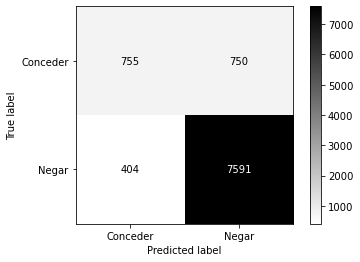

Metrics 
               precision    recall  f1-score   support

           0       0.65      0.50      0.57      1505
           1       0.91      0.95      0.93      7995

    accuracy                           0.88      9500
   macro avg       0.78      0.73      0.75      9500
weighted avg       0.87      0.88      0.87      9500

fit_time, over 4 folds attempts: 0.3205 +/- 0.01262
score_time, over 4 folds attempts: 0.00725 +/- 0.00043
test_Accuracy, over 4 folds attempts: 0.87895 +/- 0.00332
test_Precision, over 4 folds attempts: 0.91075 +/- 0.00295
test_f1, over 4 folds attempts: 0.92956 +/- 0.00233
test_Recall, over 4 folds attempts: 0.94922 +/- 0.008


Minority/Majority Class Prediction, : [1159 8341]


First 25 Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1]
Last 25 Predictions: [1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 



In [47]:
#np.random.seed(7)

tuned_params = {'alpha': 0.1,
  'colsample_bytree': 0.5,
  'gamma': 10,
  'lambda': 0.2,
  'learning_rate': 0.2,
  'max_depth': 34,
  'min_child_weight': 3,
  'subsample': 1}

#gs.best_params_

xgb_tuned = XGBClassifier(**tuned_params)
y_pred_xgb_tuned = CVS(xgb_tuned,X,y)

## Test

In [48]:
data_test = data_test_raw.copy()

In [49]:
## Data Preprossesing / Preparation

nan_transformer(data_test)
#y_knn = data_test['limite_adicional']
X_knn = data_test.drop(['id_cliente'], axis=1)
knn_imputer(X_knn)
round_col(X_knn)
data_test = pd.concat([data_test[['id_cliente']], X_knn],axis=1)

In [50]:
apply_log(data_test)
data_test['investe_exterior'] = data_test['investe_exterior'].apply(lambda x: 0 if x =='Não' else 1)
data_test['pessoa_polit_exp'] = data_test['pessoa_polit_exp'].apply(lambda x: 0 if x =='Não' else 1)

In [51]:
data_test.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
dtype: int64

In [52]:
data_test

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp
0,2,32,1.89,2.18,2.41,1.73,24.46,1,2,2.08,3.00,4,2,6,0,0
1,5,25,1.89,2.18,2.39,1.66,39.80,0,7,1.79,5.00,14,4,5,0,0
2,6,35,1.96,2.07,2.46,1.78,39.96,0,4,1.95,12.00,10,2,8,0,0
3,8,41,1.91,2.02,2.47,1.90,24.45,3,8,2.08,30.00,11,5,15,0,0
4,10,49,1.95,2.05,2.46,1.78,29.52,2,0,2.08,4.00,0,2,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,12484,48,1.91,2.13,2.42,1.57,25.38,2,7,1.79,6.00,8,4,19,1,0
2996,12487,43,2.04,1.92,2.55,1.81,27.78,2,6,2.08,30.00,20,5,11,1,0
2997,12489,44,1.78,1.99,2.54,2.02,43.31,0,2,0.69,5.00,7,1,7,0,0
2998,12495,24,1.15,2.18,2.46,1.93,35.12,4,4,2.40,11.00,4,3,3,0,0


### Using Best Model

In [53]:
X_test = data_test[selected_features]
X_test.shape, X.shape

((3000, 8), (9500, 8))

In [54]:
xgb_tuned.fit(X, y)
y_pred_xgb_tuned=xgb_tuned.predict(X_test)
y_pred_xgb_tuned

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
data_test['limite_adicional'] = y_pred_xgb_tuned
data_test['limite_adicional'] = data_test['limite_adicional'].apply(lambda x: 'Negar' if x == 1 else 'Conceder')
data_test

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,2,32,1.89,2.18,2.41,1.73,24.46,1,2,2.08,3.00,4,2,6,0,0,Conceder
1,5,25,1.89,2.18,2.39,1.66,39.80,0,7,1.79,5.00,14,4,5,0,0,Conceder
2,6,35,1.96,2.07,2.46,1.78,39.96,0,4,1.95,12.00,10,2,8,0,0,Conceder
3,8,41,1.91,2.02,2.47,1.90,24.45,3,8,2.08,30.00,11,5,15,0,0,Negar
4,10,49,1.95,2.05,2.46,1.78,29.52,2,0,2.08,4.00,0,2,12,0,0,Conceder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,12484,48,1.91,2.13,2.42,1.57,25.38,2,7,1.79,6.00,8,4,19,1,0,Negar
2996,12487,43,2.04,1.92,2.55,1.81,27.78,2,6,2.08,30.00,20,5,11,1,0,Negar
2997,12489,44,1.78,1.99,2.54,2.02,43.31,0,2,0.69,5.00,7,1,7,0,0,Conceder
2998,12495,24,1.15,2.18,2.46,1.93,35.12,4,4,2.40,11.00,4,3,3,0,0,Conceder


In [58]:
data_test['limite_adicional'].value_counts(normalize=True)

Negar      0.64
Conceder   0.36
Name: limite_adicional, dtype: float64

In [59]:
data_test[['id_cliente','limite_adicional']].to_csv("submission11.csv", index=False)

### Conclusions

As técnicas de UnderSampling e OverSampling tendem a aumentar consideravelmente as predições do tipo "Conceder", sendo o SMOTE o algoritimo onde isso mais ocorreu e no "up-weight" onde isso menos ocorreu. Talvez nesse projeto em especifico a tecnica de sub/super amostragem não fosse indicada porque utilizamos algorimos por sí só potentes e na base de teste divulgada foi revelado que a base era desbalanceda em proporções parecidas.